<a href="https://colab.research.google.com/github/EmNeuro/Music-Analysis/blob/main/1_Change_BPM_Demo_snapshot_slope_LOOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Dynamic BPM - Version 1
Below is a visual of the algorithm. In general it checks to see if snapshot probability scores are increasing or decreasing. If they are decreasing it modulates the bpm given certain parameters. However, if after 1.5 min of changing bpm probability scores continue to decrease the algorithm stops.
 

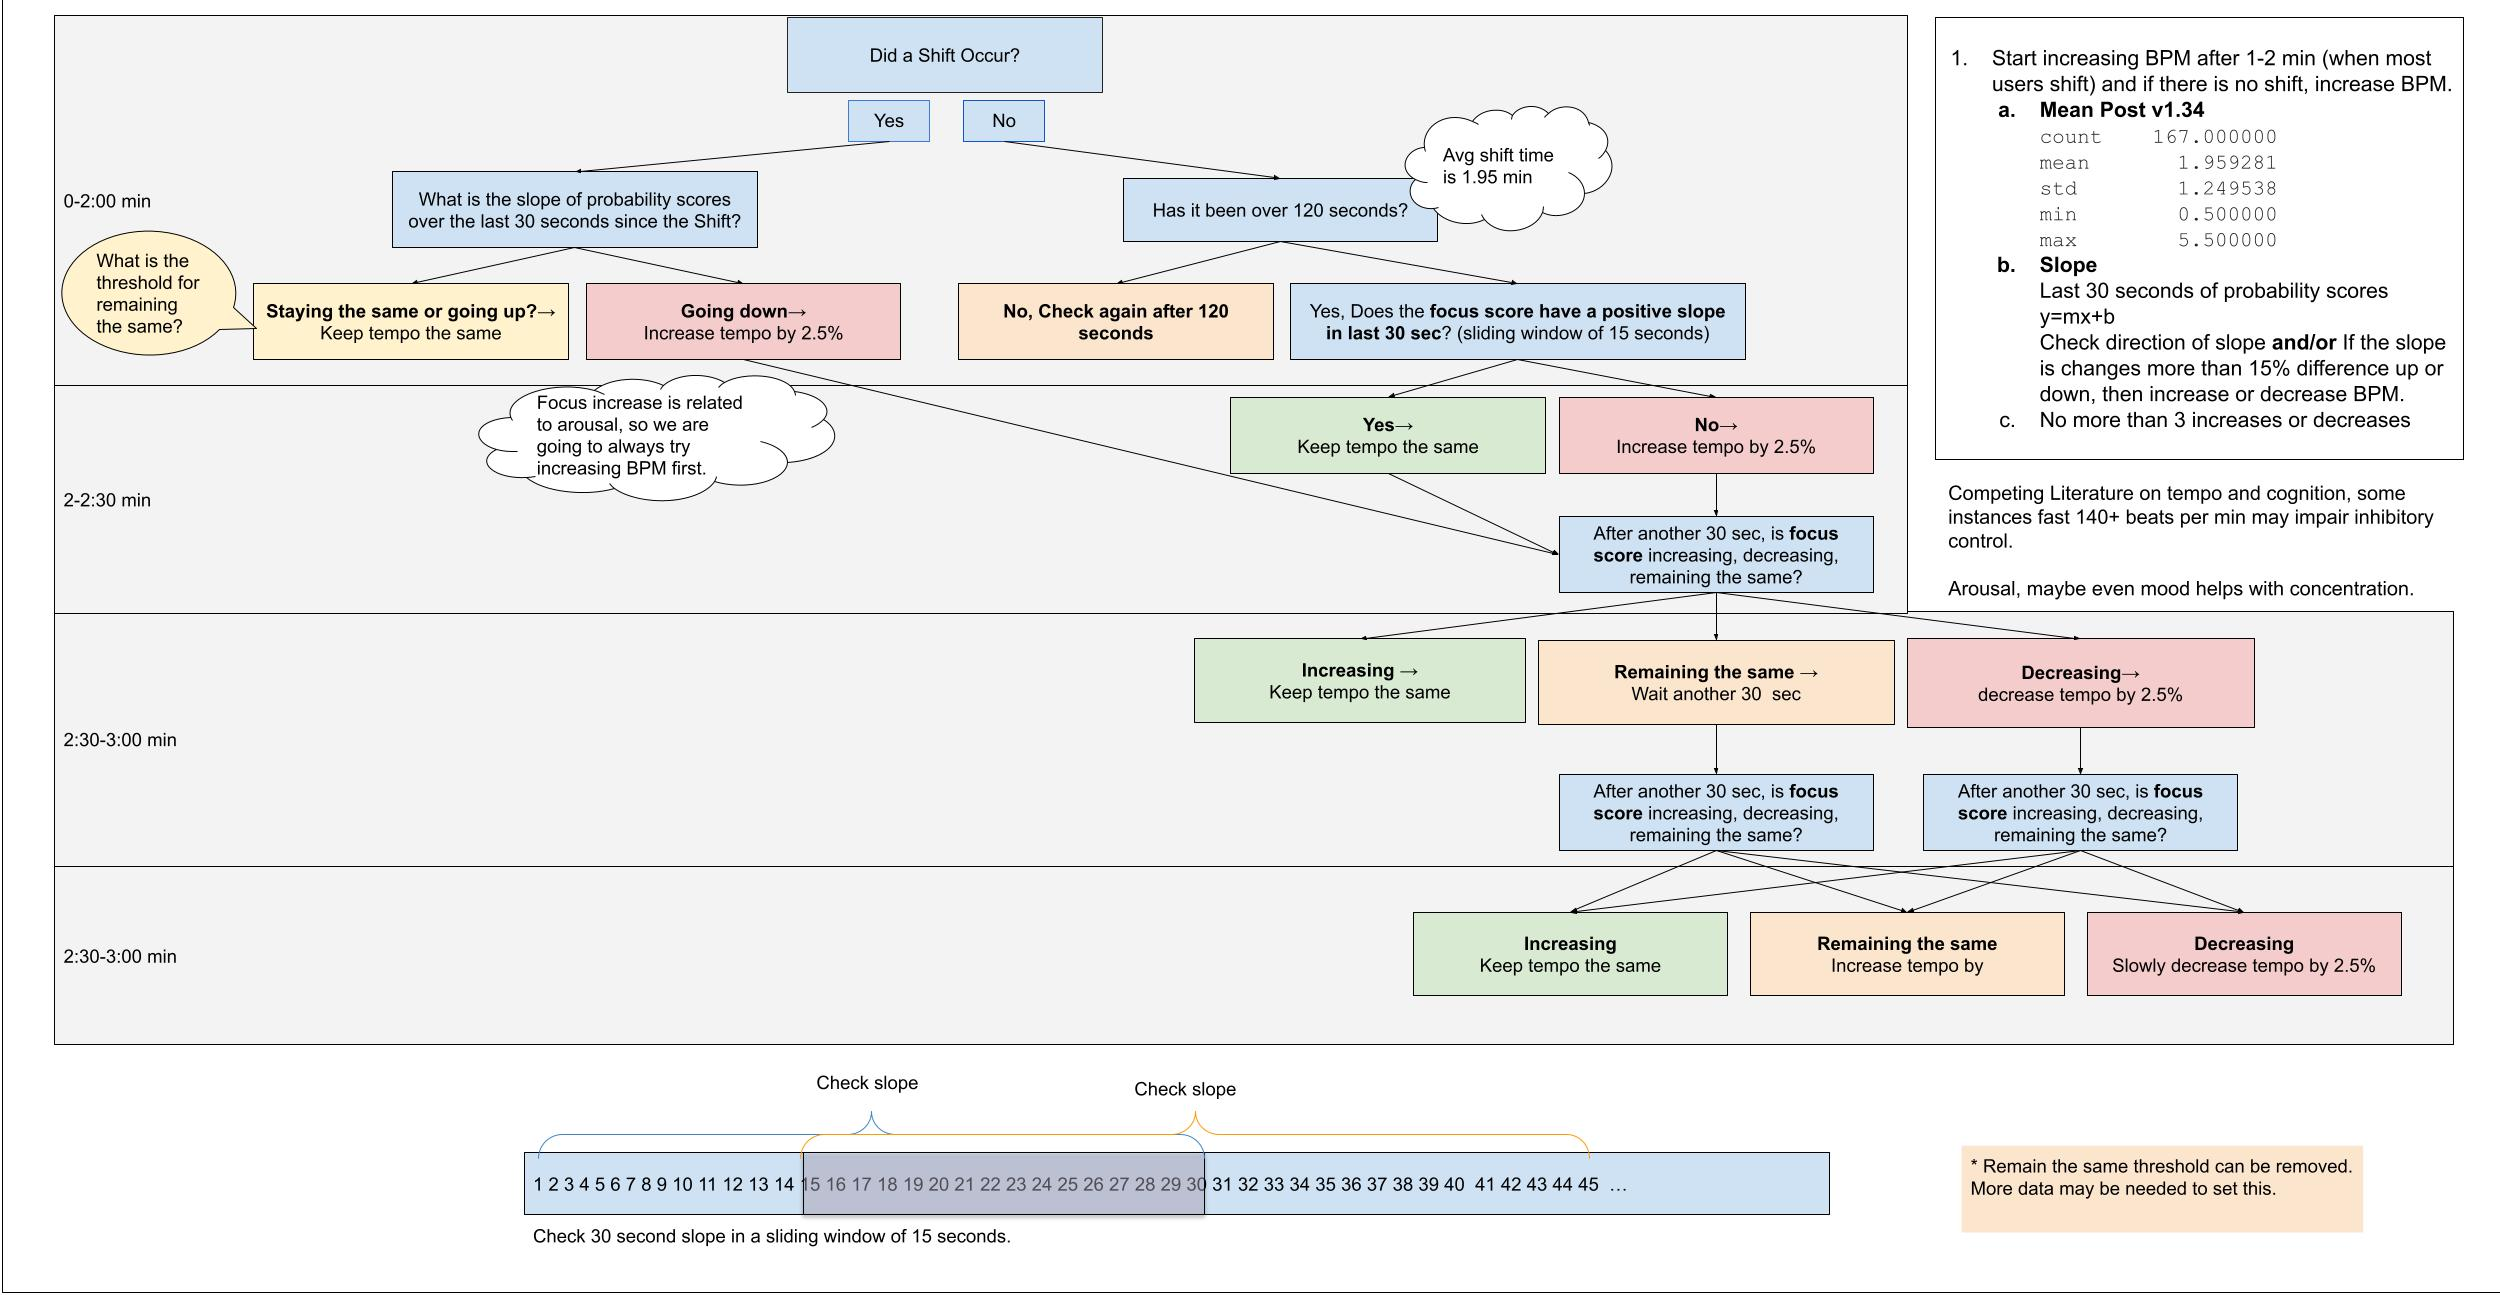

Here is another visual example of how the algorithm should work.




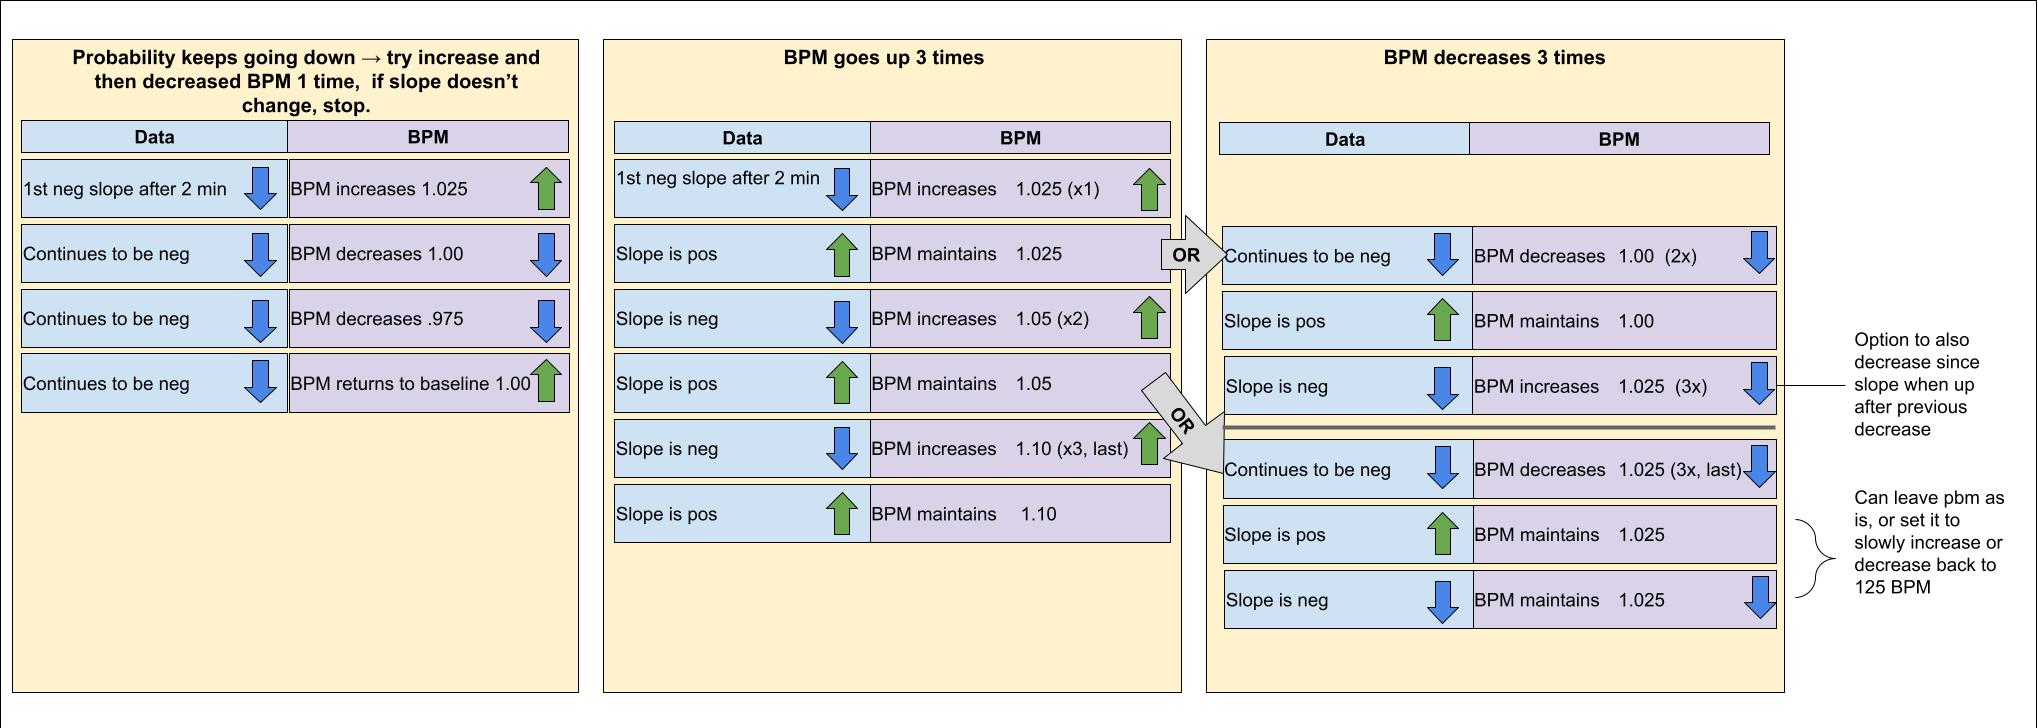

## Below is code to determine the slope of snapshots. The slope of 30 probability data points is checked every 15 seconds. 

In [3]:
#install everyting but the kitchen sink

import os
from google.colab import drive
drive.mount('/content/drive')

#music manipulation
!pip install pyrubberband
!sudo apt-get install -y rubberband-cli
import pyrubberband as pyr
import librosa
from IPython.display import Audio
import IPython.display as ipd
!pip install pydub
!pip install simpleaudio
from pydub.playback import play
!pip install ffmpeg
import ffmpeg
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install pyaudio
from pydub import AudioSegment

#stats and display
import statistics
import numpy as np
import matplotlib.pyplot as plt

#json 
from IPython.core.display import publish_display_data
import json



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree       
Reading state information... Done
rubberband-cli is already the newest version (1.8.1-7ubuntu2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autore

##Set up Data, Calcuate slopes and Determine BPM change

In [4]:
#set data dirctory 
base_folder = "/content/drive/MyDrive/Data/Alexs_Data_sample/sessions"
shift_sessions = os.listdir(base_folder)
print (shift_sessions)

['tG9t86YtGWza1PI6pPcR', '9Y3b5kbXcJMIUVt6X5IA', 'zlvu9bJLpfB9Gnq91guo', 'Z3HDUy8AlmuMhdTAwyDd', 'DPK50Be78gCy1rqAnCTc', 'z9PQE4FeaGHY4fwn6I5F', '1hbH5QvYp2tJkM4RtIta', '6KhbayEcsSs9m0X2qTT8', '3qOD1EQcny4w8YR1HJVq', 'KDSyYXVZjtpOj1huKl3V', 'G8qp5xsd4hRbvlYSi9bl', 'j6hjTfe11I3yzOj0JOBM', '7PqCH9NjlgRDw7eR0akl', '8OHPu9U19sv4Y2aSArT9', 'VOk2BflyGJpJvSRRa6KF', 'Yej5QgXRJ8elabfNDg6u', 'VTa5u2hErwG5afWkf9oW']


In [5]:
 #slope function
def trendline(x, y, order=1): # x and y corrdintates and polinomial degree of fitting (1=linear)
      coeffs = np.polyfit(x, list(y), order)
      slope = coeffs[-2]
      return float(slope)


data range: 90 - 119 slope = 0.0031 increaseing 
data range: 105 - 134 slope = 0.0006 increaseing 
data range: 120 - 149 slope = 0.0013 increaseing 
data range: 135 - 164 slope = -0.0049 decreasing dec_slope_counter = 1 first decrease, increase bpm  (1 x)
data range: 150 - 179 slope = -0.0019 decreasing dec_slope_counter = 2 /3, 2 decreased slopes in a row, decrease bpm  (1 x)
data range: 165 - 194 slope = 0.0038 increaseing 
data range: 180 - 209 slope = -0.0001 slope is very small
data range: 195 - 224 slope = -0.0013 decreasing dec_slope_counter = 3 /3 decreaseing slope, increase pbm (2 x)
data range: 210 - 239 slope = 0.0013 increaseing 
data range: 225 - 254 slope = 0.0001 slope is very small
data range: 240 - 269 slope = 0.0026 increaseing 
data range: 255 - 284 slope = -0.0002 decreasing dec_slope_counter = 4 do nothing for now
data range: 270 - 299 slope = -0.0025 decreasing dec_slope_counter = 5 do nothing for now

Z3HDUy8AlmuMhdTAwyDd
BPMS: [125, 125, 125, 127.5, 125.0, 125.0

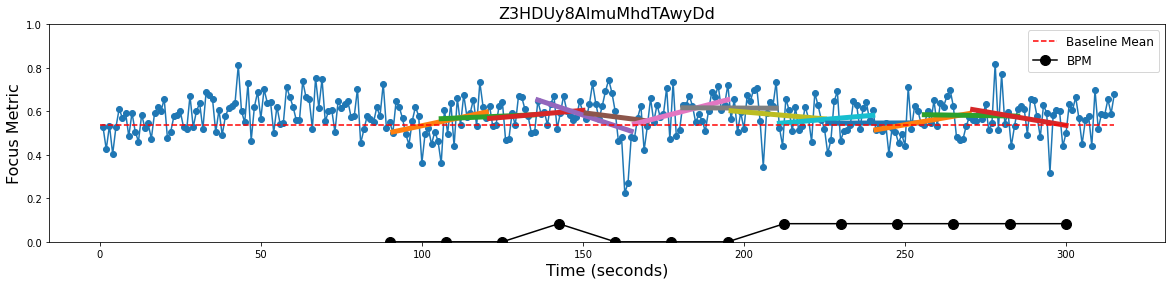

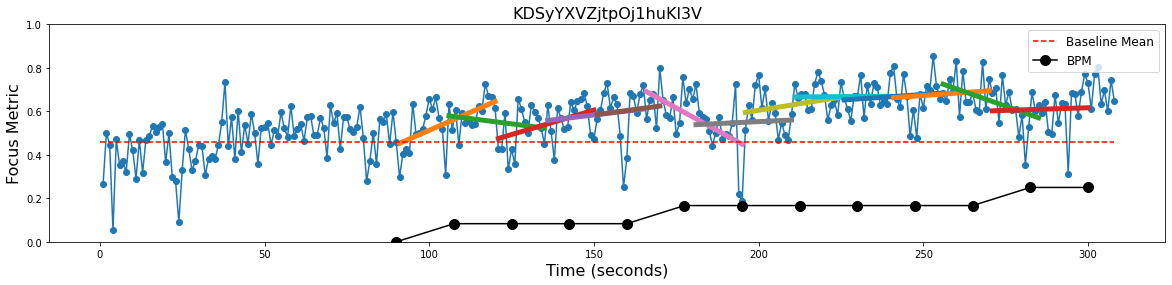

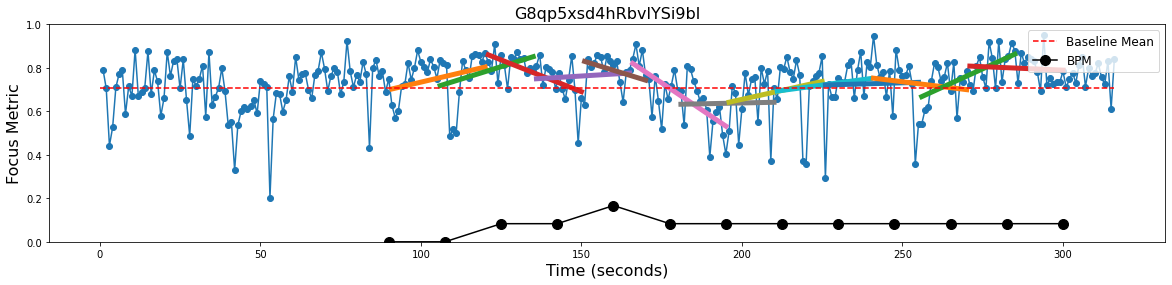

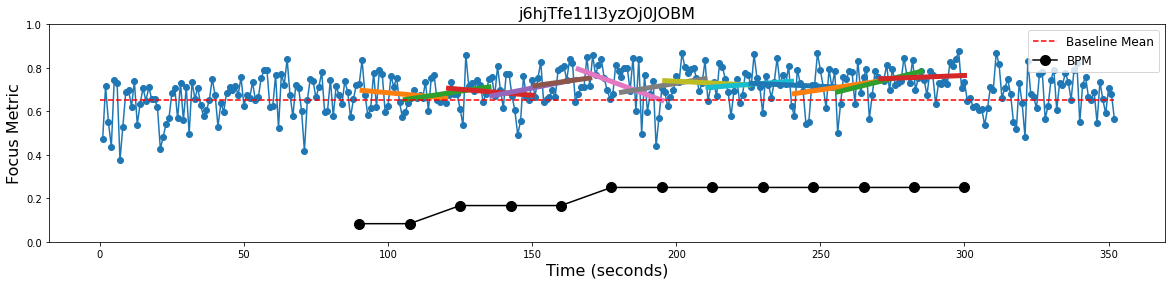

In [6]:
#Lists to keep all session's bpms
bpms_sess=[]
slope_sess=[]

##loop though each session in folder, pull out data, calculate slope and graph it. 

for sess in shift_sessions:
    #open snapshot json 
    fname = os.path.join(base_folder, sess, 'snapshots.json')
    f = open(fname)
    snapshot_data = json.load(f)

    #open session json  
    fname = os.path.join(base_folder, sess, 'session.json')
    f = open(fname)
    sess_metadata = json.load(f)
    
    #grab scores and baseline median
    baseline_mean = sess_metadata['scores']['baselineMedianScore']

    #open lists for time and probability data
    times = []
    pdata = []

    
##loop through snapshot data and pull timestamp and probablity 
    for d in snapshot_data:
        times.append(d['timestamp'])
        pdata.append(d['probability'])

    times = np.array(times[::-1])
    pdata = np.array(pdata[::-1])

    #Only process sessions greater than 5 min to reduce sample size
    if len(times)>=300: #300/60 = 5

      start = 90 #start checking slope at 1.5 min in
      end = start + 30 # calculate slope for 30 sec worth of data
      bpm = 125 # all Evoked response tracks are 125 BPM
      bpms = [] #open list to collect all BPM for each chunk of time
      data_chunks = [] #check to make sure timing is correct
      slopes = [] #list of slope values
      slope_sess.append(slopes)

      #counters 
      inc_slope_counter = 0 #counter for number of timmes slope increases --- not using this a the momment
      dec_slope_counter = 0 # counter for number of times the slope deceases --- limits number of time bpm changes
      double_neg_count = 0 # counter for number of times there was at least 2 back to back windows of decreasing slopes
      dec_bpm_counter = 0 # counter for number of times the bpm decreased
      inc_bpm_counter = 0 # counter for number of times the bpm increased

##loop though data to isolate 30 pt chucks of data and calculate slope
      for chunck in range(0,13): #approximately 13 slopes calcualted for +5 min sessions

        datapoints = list(range(start,end)) # x corrdinate (how many data points)
        x = datapoints #x coordinates "time"
        y = pdata[start:end] # y corrdinate (which data points to look at)
        data_chunks.append([start, end]) #append start and end time to list
        resultent = trendline(x, y) #runs function to get slop given x and y.
        #p = np.poly1d(np.polyfit(x, y, 1)) This is the function's slope formula
        slopes.append(resultent) # add slope to list


        # is slope decreasing?
        if resultent<-0.0002:   #slope threshold should be .002 determined by emily, aj and alex data, here its reduced for testing only
          dec_slope_counter += 1
          #print ("dec_slope_counter=", dec_slope_counter )
          #first instance of a decreasing or negatice slope--> increase bpm
          if dec_slope_counter == 1: 
            inc_bpm_counter += 1
            bpm=bpm+2.5
            bpms.append(bpm)
            print ("data range:", np.min(datapoints),"-", np.max(datapoints), "slope =","{:.04f}".format(resultent),"decreasing dec_slope_counter =", dec_slope_counter, "first decrease, increase bpm ","({} x)".format(inc_bpm_counter))

        # second or third instance of a decreased slope
          if dec_slope_counter >1 and dec_slope_counter<4:

            #check if previous slope was neg
            #if last slope was decreasing --> reverse previous increase of bpm
            if slopes[-2] < -.0002 and slopes[-3]>-.0002:
              double_neg_count += 1
              dec_bpm_counter += 1
              bpm=bpm-2.5
              bpms.append(bpm)
              print ("data range:", np.min(datapoints),"-", np.max(datapoints), "slope =","{:.04f}".format(resultent),"decreasing dec_slope_counter =", dec_slope_counter,  "/3, 2 decreased slopes in a row, decrease bpm ","({} x)".format(dec_bpm_counter))
            
            #if there are three decreases in a row --> try decreasing bpm more to see if a sloper than normal tempo works. 
            if slopes[-2] < -.0002 and slopes[-3]<-.0002:
              double_neg_count += 1
              dec_bpm_counter += 1
              bpm=bpm-2.5
              bpms.append(bpm)
              print ("data range:", np.min(datapoints),"-", np.max(datapoints), "slope =","{:.04f}".format(resultent),"decreasing dec_slope_counter =", dec_slope_counter,  "/3, 3 decreased slopes in a row, decrease bpm ","({} x)".format(dec_bpm_counter))
            
            #if there are four decreases in a row, stop decreasing and go back up to baseline. 
            if slopes[-2] < -.0002 and slopes[-3]<-.0002 and slopes[-4]<-.0002:
              double_neg_count += 1
              inc_bpm_counter += 1
              bpm=bpm+2.5
              bpms.append(bpm)
              print ("data range:", np.min(datapoints),"-", np.max(datapoints), "slope =","{:.04f}".format(resultent),"decreasing dec_slope_counter =", dec_slope_counter,  "/3, 4 decreased slopes in a row, increase bpm to baseline","({} x)".format(inc_bpm_counter))
            
            #if the slope was previously increasing and now decreasing then increase again  
            else:
              if  slopes[-2] > -.0002:
                bpm=bpm+2.5
                inc_bpm_counter += 1
                bpms.append(bpm)
                print ("data range:", np.min(datapoints),"-", np.max(datapoints), "slope =","{:.04f}".format(resultent),"decreasing dec_slope_counter =", dec_slope_counter, "/3 decreaseing slope, increase pbm","({} x)".format(inc_bpm_counter))
         
          #if there has been more than 3 decreases already then 
          else:
            if dec_slope_counter> 1:
              bpms.append(bpm)
              print ("data range:", np.min(datapoints),"-", np.max(datapoints), "slope =","{:.04f}".format(resultent),"decreasing dec_slope_counter =", dec_slope_counter, "do nothing for now" )


        # is slope increasing?
        if resultent>0.0002:
          bpm=bpm
          bpms.append(bpm)
          print ("data range:", np.min(datapoints),"-", np.max(datapoints),"slope =","{:.04f}".format(resultent),"increaseing ")

       
        # is slope relativley flat? Dont' change BPM
        if resultent <0.0002 and resultent >-0.0002:
          bpms.append(bpm)
          print ("data range:", np.min(datapoints),"-", np.max(datapoints), "slope =","{:.04f}".format(resultent),'slope is very small')

        #shift slope window over 15 seconds
        start=start+15 #adds 15 seconds to start time
        end=end+15 # adds 15 seconds to end time

      print ("")
      print (sess)
      print ("BPMS:",bpms)
      #print ("data chuncks:", data_chunks)
      print ("slopes:", slopes)
      print ("")
      bpms_sess.append(bpms)


######FIGURES#######

      #graph data slopes and bpm
      #set x and y data
      points =len(list(pdata)) #changes for each session
      x = np.linspace(1,points,num=points) #creates linear data to represent time
      y = pdata # session probability data

      #set m and b of slopes for each data chunk
      m1, b1 = np.polyfit(x[90:120], y[90:120], 1) #linear
      m2, b2 = np.polyfit(x[105:135], y[105:135], 1) #linear
      m3, b3 = np.polyfit(x[120:150], y[120:150], 1) #linear
      m4, b4 = np.polyfit(x[135:165], y[135:165], 1) #linear
      m5, b5 = np.polyfit(x[150:180], y[150:180], 1) #linear
      m6, b6 = np.polyfit(x[165:195], y[165:195], 1) #linear
      m7, b7 = np.polyfit(x[180:210], y[180:210], 1) #linear
      m8, b8 = np.polyfit(x[195:225], y[195:225], 1) #linear
      m9, b9 = np.polyfit(x[210:240], y[210:240], 1) #linear
      m10, b10 = np.polyfit(x[225:255], y[225:255], 1) #linear
      m11, b11 = np.polyfit(x[240:270], y[240:270], 1) #linear
      m12, b12 = np.polyfit(x[255:285], y[255:285], 1) #linear
      m13, b13 = np.polyfit(x[270:300], y[270:300], 1) #linear

      # create plot
      fig, ax = plt.subplots(1,1,figsize=(20,4)) # set size

      #plot x and y 
      plt.plot(x, y,'-o') 

      #plot slopes
      plt.plot(x[90:120],  m1*x[90:120] +b1, linewidth=5)
      plt.plot(x[105:135], m2*x[105:135] +b2, linewidth=5)
      plt.plot(x[120:150], m3*x[120:150] +b3, linewidth=5)
      plt.plot(x[135:165], m4*x[135:165] +b4, linewidth=5)
      plt.plot(x[150:170], m5*x[150:170] +b5, linewidth=5)      
      plt.plot(x[165:195], m6*x[165:195] +b6, linewidth=5)
      plt.plot(x[180:210], m7*x[180:210] +b7, linewidth=5)
      plt.plot(x[195:225], m8*x[195:225] +b8, linewidth=5)
      plt.plot(x[210:240], m9*x[210:240] +b9, linewidth=5)
      plt.plot(x[225:255], m10*x[225:255] +b10, linewidth=5)
      plt.plot(x[240:270], m11*x[240:270] +b11, linewidth=5)
      plt.plot(x[255:285], m12*x[255:285] +b12, linewidth=5)
      plt.plot(x[270:300], m13*x[270:300] +b13, linewidth=5)

      #plot baseline
      _ = ax.plot([0,points], [statistics.median(pdata[:20]), statistics.median(pdata[:20])], #mean of first 25 data points
                  'r--', label='Baseline Mean')

      #plot bpm direction
      bpms_small=[(x-125)/30 for x in bpms] # reduce bmp
      x2 = np.linspace (90,300,num=13) #starts after baseline and the next 30seconds
      _ = ax.plot(x2, bpms_small, '-o', ms=10, color='k', label='BPM')# direction of bpm

      #set lables and legend
      _ = ax.set_ylim([0, 1])
      _ = ax.set_ylabel("Focus Metric", fontsize=16)
      _ = ax.set_xlabel("Time (seconds)", fontsize=16)
      _ = ax.set_title(sess, fontsize=16)
      _ = ax.legend(loc='upper right', fontsize=12)

      #Prints to make sure slopes are calcualted consistantly 
      #print (m, b, m2, m3)
      #print (len(x), len(pdata))


In [ ]:
print (bpms_sess)

[[125, 125, 125, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 130.0], [125, 125, 125, 125, 125, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 130.0, 130.0], [125, 125, 127.5, 127.5, 130.0, 132.5, 132.5, 132.5, 132.5, 132.5, 132.5, 132.5, 132.5], [125, 125, 125, 125, 125, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5]]


##Modify Music Track BPM based on analysis above
Below is a very clunky way to get an idea of what the entire track would sound like given data and parameters above. Looks for at least 3 instances of decreased slope. 

Does not implement part of algorithm that reduces bpm.
Segments track into 30 second chunks, and increases tempo based on slope, then stitches the chunks back together with some fading and cross over to reduce "pop" noise. 

In [8]:
#folder with musict tracks
base_dir ='/content/drive/MyDrive/Revised_Nov_2021_EK/Med_Stim/'

#for each track in folder, modify based on pattern of snapshot probability. 
for track in os.listdir(base_dir):
  #wav = os.path.join(base_dir, track)
  if track.endswith(".wav"): #ignores other types such mp3, m4a etc.
    current_track =os.path.join(base_dir, track)
    song = AudioSegment.from_wav(current_track)#pydub wants to use audiosegment
    track_name = os.path.basename(current_track)

    songlen = int(len(song)/15000) # number of 30 segments in song

    print ("starting", track_name)
    print("             ")
    print (songlen)


    #segment track
    start=120*1000 #starts at 0 sec
    end=start + 15*1000 #each segment is 15 seconds-- can't do sliding window here
    seg_list=[]

    #first 120 seconds of song
    seg_list.append(song[0:120000])

    #slice the current track into 15 second chunks 
    for chunk in range(0,12):
      seg_list.append(song[start:end])
      seg_chunk="seg_{0}_{1}_second=song[{0}:{1}]".format(start, end)
      start=start+15000
      end=end+15000 
      print(seg_chunk)


    #modify segments based on slope
    start=120
    end=135
    inital_speed_increase = 1.025 ## change percent speedup
    increase_speed =0.025
    current_speed = 0
    counter = 0
    new_segments=[]

    #increase speed for first three instances of a decreasing slope. 
    for bpmlist in bpms_sess[1:2]:
      print (bpmlist)
      for BPM in range(0, 12): #start at 120 seconds
       
        if bpmlist[BPM-1]<bpmlist[BPM]:
          counter += 1

          if counter == 1: 
            print (start,"-", end, "seconds, bpm increased", bpmlist[BPM-1], "to", bpmlist[BPM])
            current_speed= inital_speed_increase #increase speed
            new_segments.append(seg_list[BPM].speedup(playback_speed=current_speed)) ## change percent speedup, same as above
            print("current speed", current_speed)
        
          if counter > 1:
            if bpmlist[BPM-1]<bpmlist[BPM]:
              print (start,"-", end, "seconds, bpm increased", bpmlist[BPM-1], "to", bpmlist[BPM])
              current_speed= current_speed + increase_speed #increase speed
              new_segments.append(seg_list[BPM].speedup(playback_speed=current_speed)) ## change percent speedup, same as above
              print("current speed", current_speed)

            if bpmlist[BPM-1]>bpmlist[BPM]:
              print (start,"-", end, "seconds, bpm decreased", bpmlist[BPM-1], "to", bpmlist[BPM])
              current_speed= inital_speed_increase-.025 #decrease speed
              new_segments.append(seg_list[BPM].speedup(playback_speed=current_speed)) ## change percent speedup, same as above
              print("current speed", current_speed)

        if bpmlist[BPM-1]==bpmlist[BPM]:
          print (start,"-", end, "seconds, bpm maintained", bpmlist[BPM-1], "to", bpmlist[BPM])
          current_speed= current_speed #same speed
          new_segments.append(seg_list[BPM].speedup(playback_speed=current_speed)) ## change percent speedup, same as above
          print("current speed", current_speed)


        start=start+15
        end=end+15
      print ("new seg", (new_segments), "len = ",new_segments)

#join segments together with a crossfade between each one to muffle "pop sound"
    first=new_segments[0].append(new_segments[1],crossfade=500)
    second=first.append(new_segments[1],crossfade=500)
    third=second.append(new_segments[2],crossfade=500)
    fourth=third.append(new_segments[3],crossfade=500)
    fifth=fourth.append(new_segments[4],crossfade=500) #modified segments
    sixth=fifth.append(new_segments[5],crossfade=500)
    seventh=sixth.append(new_segments[6],crossfade=500)
    eigth=seventh.append(new_segments[7],crossfade=500)
    ninth=eigth.append(new_segments[8],crossfade=500)
    new_track=ninth
    #add fade to the begining and end
    new_track_fadeCF500= new_track.fade_in(1000).fade_out(1000)

#export modified track
    new_track_fadeCF500.export('/content/drive/MyDrive/Revised_Nov_2021_EK/'+"snapshot_BPM_modified_{0}_{1}_CF500Fade.wav".format(increase_speed,track_name), format="wav")
    print ("exporting BPM_modified_{0}_{1}_CF500Fade.wav".format(increase_speed,track_name))
    print ("new segments",len(new_segments))
    print ("seg list", len(seg_list))
    print ("bpm list", len(bpmlist))

    print(" ")
    print(" ")

starting NeurosityShift-Ambient2A125bpmhighval,midenrgyMedstim.m4a.wav
             
23
seg_120000_135000_second=song[120000:135000]
seg_135000_150000_second=song[135000:150000]
seg_150000_165000_second=song[150000:165000]
seg_165000_180000_second=song[165000:180000]
seg_180000_195000_second=song[180000:195000]
seg_195000_210000_second=song[195000:210000]
seg_210000_225000_second=song[210000:225000]
seg_225000_240000_second=song[225000:240000]
seg_240000_255000_second=song[240000:255000]
seg_255000_270000_second=song[255000:270000]
seg_270000_285000_second=song[270000:285000]
seg_285000_300000_second=song[285000:300000]
[125, 127.5, 127.5, 127.5, 127.5, 130.0, 130.0, 130.0, 130.0, 130.0, 130.0, 132.5, 132.5]
135 - 150 seconds, bpm increased 125 to 127.5
current speed 1.025
150 - 165 seconds, bpm maintained 127.5 to 127.5
current speed 1.025
165 - 180 seconds, bpm maintained 127.5 to 127.5
current speed 1.025
180 - 195 seconds, bpm maintained 127.5 to 127.5
current speed 1.025
195 - 210

In [ ]:
for bpmlist in bpms_sess[1:2]:
  print (bpmlist)
  #print (bpmlist[-1])
  print (len(bpmlist))
  for BPM in range(3, 11): 
    print (bpmlist[BPM-1], bpmlist[BPM])


[125, 125, 125, 125, 125, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 130.0, 130.0]
13
125 125
125 125
125 127.5
127.5 127.5
127.5 127.5
127.5 127.5
127.5 127.5
127.5 127.5


In [ ]:
for slopelist in slope_sess[1:2]:
  print (slopelist)
  #print (bpmlist[-1])
  print (len(slopelist))
  for slope in range(3, 11): 
    print (slopelist[slope-1], slopelist[slope])

[0.006631082513548336, -0.0019411205187734534, 0.004503715346184508, 0.0018046745420057793, 0.002042853521671847, -0.008309081920301602, 0.0007296262208283279, 0.002430014455869137, 0.00011432720582926126, 0.001049354992305476, 0.0010974688203925598, -0.005325394848056967, 0.00048808861597043093]
13
0.004503715346184508 0.0018046745420057793
0.0018046745420057793 0.002042853521671847
0.002042853521671847 -0.008309081920301602
-0.008309081920301602 0.0007296262208283279
0.0007296262208283279 0.002430014455869137
0.002430014455869137 0.00011432720582926126
0.00011432720582926126 0.001049354992305476
0.001049354992305476 0.0010974688203925598
